In [1]:
import pandas as pd
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns




In [2]:
# Load dataset
df = pd.read_csv('Ratings.csv')
df = df[df['Book-Rating'] > 0]  # remove zero ratings
df

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [3]:
df.duplicated().sum()

0

In [4]:
df['Book-Rating'].value_counts().sort_index()

Book-Rating
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64

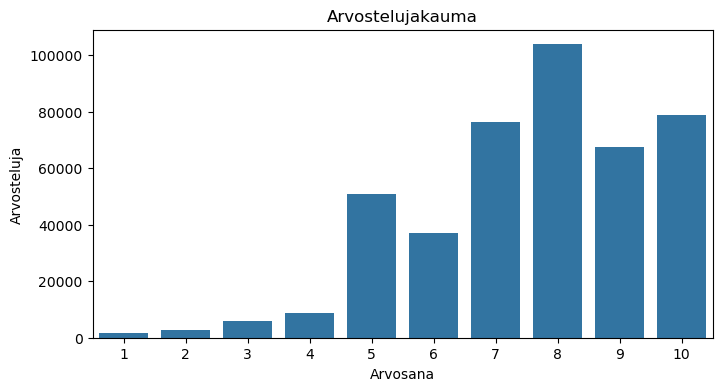

In [5]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Book-Rating", data=df, order=sorted(df["Book-Rating"].unique()))
plt.title("Arvostelujakauma")
plt.xlabel("Arvosana")
plt.ylabel("Arvosteluja")
plt.show()

In [6]:
book_counts = df['ISBN'].value_counts()

print("Unnique books:", df['ISBN'].nunique())
print("Total number of reviews:", len(df))

Unnique books: 185973
Total number of reviews: 433671


In [7]:
print(book_counts)

ISBN
0316666343     707
0971880107     581
0385504209     487
0312195516     383
0679781587     333
              ... 
0140441905       1
0886777267       1
0671697951       1
0553560956       1
05162443314      1
Name: count, Length: 185973, dtype: int64


In [8]:
book_counts.describe()

count    185973.000000
mean          2.331903
std           6.834667
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         707.000000
Name: count, dtype: float64

In [9]:
#Reviews per user
user_counts = df['User-ID'].value_counts()

user_counts.describe()

count    77805.000000
mean         5.573819
std         44.001879
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       8524.000000
Name: count, dtype: float64

In [10]:
#In item–item recommendations, each book should have at least a few reviews so that similarities can be calculated reliably.

#Below we investigate how many books and how many reviews are retained at different limits (1, 2, 4, 6, 8, 10 reviews per book).

thresholds = 


SyntaxError: invalid syntax (893604055.py, line 5)

In [ ]:
# Filter active users and popular items to reduce matrix size
user_counts = df['User-ID'].value_counts()
active_users = user_counts[user_counts > 20].index   # keep users with >20 ratings
df = df[df['User-ID'].isin(active_users)]
df


In [ ]:
item_counts = df['ISBN'].value_counts()
popular_items = item_counts[item_counts > 20].index  # keep items with >20 ratings
df = df[df['ISBN'].isin(popular_items)]

print("Users:", df['User-ID'].nunique(), "Items:", df['ISBN'].nunique())

In [ ]:
# Prepare Surprise dataset
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['User-ID', 'ISBN', 'Book-Rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)


# Train KNN model (limit neighbors to reduce memory)
sim_options = {
    'name': 'cosine',
    'user_based': False  # switch to False for item-based
}
algo = KNNBasic(k=40, sim_options=sim_options)  # k=40 keeps it manageable
algo.fit(trainset)


In [ ]:
# Evaluate
predictions = algo.test(testset)
accuracy.rmse(predictions)


In [ ]:
# Visualize predictions
true_ratings = [pred.r_ui for pred in predictions]
est_ratings = [pred.est for pred in predictions]
data_plot = pd.DataFrame({'true': true_ratings, 'predicted': est_ratings})
g = sns.jointplot(data=data_plot, x='true', y='predicted', kind='kde')
g.fig.suptitle('Test predictions (KNN)', fontsize=12)
plt.show()


In [ ]:

# Recommend top N items for a user
def recommend_books(algo, df, user_id, n=5):
    all_items = df['ISBN'].unique()
    rated_items = df[df['User-ID'] == user_id]['ISBN'].unique()
    unrated_items = [item for item in all_items if item not in rated_items]

    predictions = [algo.predict(user_id, item) for item in unrated_items]
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    return [(pred.iid, pred.est) for pred in top_n]

# Example: Recommend top 5 books for a sample user
sample_user = df['User-ID'].iloc[0]
recommendations = recommend_books(algo, df, sample_user, n=5)
print(f"Top recommendations for User {sample_user}:", recommendations)


In [ ]:
!python -m pip install nbconvert

import nbformat
from nbconvert import HTMLExporter

# Load notebook
with open("book_reco.ipynb") as f:
    nb = nbformat.read(f, as_version=4)

# Convert to HTML
html_exporter = HTMLExporter()
(body, resources) = html_exporter.from_notebook_node(nb)

# Save HTML
with open("book_reco.html", "w", encoding="utf-8") as f:
    f.write(body)